In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, median, col, when, lit, mean, count, sum as sum_, coalesce
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType, FloatType
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc as sklearn_auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Khởi tạo SparkSession

In [ ]:
# Khởi tạo SparkSession
spark = SparkSession.builder \
    .appName("Dự đoán vỡ nợ khoản vay") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Hàm xử lý ngoại lai

In [ ]:
# Hàm xử lý ngoại lai
def cap_outliers(df, col_name, relative_error=0.01, multiplier=1.5):
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], relative_error)
    if len(quantiles) < 2:
        return df
    q1, q3 = quantiles
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return df.withColumn(
        col_name,
        when(col(col_name) < lower_bound, lower_bound)
        .when(col(col_name) > upper_bound, upper_bound)
        .otherwise(col(col_name))
    )

# Hàm in số cột và hàng của biến huấn luyện

In [ ]:
# Hàm in số cột và hàng của biến huấn luyện
def print_feature_info(df, numeric_cols, categorical_cols):
    numeric_cols_filtered = [c for c in numeric_cols if c in df.columns]
    categorical_ohe_cols = [col + "_ohe" for col in categorical_cols]
    assembler_inputs = numeric_cols_filtered + categorical_ohe_cols
    print(f"Số cột biến dùng trong huấn luyện: {len(assembler_inputs)}")
    print(f"Các cột: {assembler_inputs}")
    print(f"Số hàng của dữ liệu huấn luyện: {df.count()}")

# Đọc dữ liệu

In [ ]:
# 1. Đọc dữ liệu
try:
    df = spark.read.csv("application_train.csv", header=True, inferSchema=True)
    print(f"DataFrame application_train.csv có {df.count()} dòng và {len(df.columns)} cột.")
except Exception as e:
    print(f"Lỗi khi đọc application_train.csv: {e}")
    sys.exit(1)

try:
    df_prev = spark.read.csv("previous_application.csv", header=True, inferSchema=True)
    print(f"DataFrame previous_application.csv có {df_prev.count()} dòng và {len(df_prev.columns)} cột.")
except Exception as e:
    print(f"Lỗi khi đọc previous_application.csv: {e}")
    sys.exit(1)

# Tính tỷ lệ vỡ nợ (TARGET = 1)
tong_so_dong = df.count()
so_luong_von_no = df.filter(col("TARGET") == 1).count()
ty_le_von_no = (so_luong_von_no / tong_so_dong) * 100
print(f"Tỷ lệ vỡ nợ (TARGET = 1): {ty_le_von_no:.2f}%")

DataFrame application_train.csv có 307511 dòng và 122 cột.
DataFrame previous_application.csv có 1670214 dòng và 37 cột.
Tỷ lệ vỡ nợ (TARGET = 1): 8.07%


# Tiền xử lý application_train.csv

In [ ]:
# Xử lý giá trị bất thường DAYS_EMPLOYED
df = df.withColumn(
    "DAYS_EMPLOYED",
    when(col("DAYS_EMPLOYED") == 365243, None).otherwise(col("DAYS_EMPLOYED"))
)

# Danh sách cột numeric và categorical
numeric_cols = [
    "EXT_SOURCE_2", "DAYS_BIRTH", "AMT_GOODS_PRICE", "DAYS_EMPLOYED", "CNT_FAM_MEMBERS",
    "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_ID_PUBLISH", "EXT_SOURCE_1",
    "EXT_SOURCE_3"
]
categorical_cols = [
    "CODE_GENDER", "NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE", "OCCUPATION_TYPE",
    "FLAG_OWN_CAR", "FLAG_OWN_REALTY"
]

# Điền giá trị thiếu cho numeric (median) và categorical ("Unknown")
median_dict = {}
for c in numeric_cols:
    if c in df.columns:
        median_val = df.approxQuantile(c, [0.5], 0.01)[0] or 0
        median_dict[c] = median_val
df = df.fillna(median_dict)
df = df.fillna({c: "Unknown" for c in categorical_cols if c in df.columns})

# Xử lý ngoại lai cho cột numeric
for col_name in numeric_cols:
    if col_name in df.columns:
        df = cap_outliers(df, col_name)

# Tạo biến nhị phân
df = df.withColumn("CODE_GENDER_INDEX", when(col("CODE_GENDER") == "M", 1).otherwise(0))
df = df.withColumn("FLAG_OWN_CAR_INDEX", when(col("FLAG_OWN_CAR") == "Y", 1).otherwise(0))
df = df.withColumn("FLAG_OWN_REALTY_INDEX", when(col("FLAG_OWN_REALTY") == "Y", 1).otherwise(0))

# Tạo đặc trưng mới
df = df.withColumn("AGE", (col("DAYS_BIRTH") / -365).cast("integer"))
df = df.withColumn("YEARS_EMPLOYED", (col("DAYS_EMPLOYED") / -365).cast("integer"))
df = df.withColumn("DAYS_ID_PUBLISH_YEAR", (col("DAYS_ID_PUBLISH") / -365).cast("integer"))
if "DAYS_LAST_PHONE_CHANGE" in df.columns:
    df = df.withColumn("DAYS_LAST_PHONE_CHANGE_YEAR", (col("DAYS_LAST_PHONE_CHANGE") / -365).cast("integer"))
df = df.withColumn("INCOME_TO_CREDIT_RATIO", col("AMT_INCOME_TOTAL") / col("AMT_CREDIT"))
df = df.withColumn("CREDIT_TO_INCOME", col("AMT_CREDIT") / col("AMT_INCOME_TOTAL"))
df = df.withColumn("INCOME_PER_PERSON", col("AMT_INCOME_TOTAL") / col("CNT_FAM_MEMBERS"))
df = df.withColumn("ANNUITY_TO_INCOME", col("AMT_ANNUITY") / col("AMT_INCOME_TOTAL"))
df = df.withColumn("CREDIT_TO_GOODS", col("AMT_CREDIT") / col("AMT_GOODS_PRICE"))
df = df.withColumn("EMPLOYMENT_TO_AGE", col("YEARS_EMPLOYED") / col("AGE"))
df = df.withColumn(
    "EXT_SOURCE_AVG",
    (coalesce(col("EXT_SOURCE_1"), lit(0)) + col("EXT_SOURCE_2") + coalesce(col("EXT_SOURCE_3"), lit(0))) / 3
)

# Tiền xử lý previous_application.csv

In [ ]:
numeric_prev_columns = [
    "AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE",
    "DAYS_DECISION", "CNT_PAYMENT", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION",
    "DAYS_LAST_DUE", "DAYS_TERMINATION", "NFLAG_INSURED_ON_APPROVAL"
]
categorical_prev_columns = [
    "NAME_CONTRACT_TYPE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE",
    "CODE_REJECT_REASON", "NAME_CLIENT_TYPE"
]

# Điền giá trị thiếu
median_dict_prev = {}
for c in numeric_prev_columns:
    if c in df_prev.columns:
        median_val = df_prev.approxQuantile(c, [0.5], 0.01)[0] or 0
        median_dict_prev[c] = median_val
df_prev = df_prev.fillna(median_dict_prev)
df_prev = df_prev.fillna({c: "Unknown" for c in categorical_prev_columns if c in df_prev.columns})

# Xử lý ngoại lai
outlier_cols = ["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "DAYS_DECISION", "AMT_GOODS_PRICE"]
for col_name in outlier_cols:
    if col_name in df_prev.columns:
        df_prev = cap_outliers(df_prev, col_name)

# Tạo biến nhị phân
df_prev = df_prev.withColumn("IS_APPROVED", when(col("NAME_CONTRACT_STATUS") == "Approved", 1).otherwise(0))
df_prev = df_prev.withColumn("IS_REJECTED", when(col("NAME_CONTRACT_STATUS") == "Refused", 1).otherwise(0))

# Tổng hợp theo SK_ID_CURR
df_prev_agg = df_prev.groupBy("SK_ID_CURR").agg(
    count("*").alias("count_prev_apps"),
    avg("AMT_APPLICATION").alias("mean_amt_application"),
    avg("AMT_CREDIT").alias("mean_amt_credit"),
    avg("CNT_PAYMENT").alias("mean_cnt_payment"),
    avg("DAYS_DECISION").alias("mean_dpd_decision"),
    avg("IS_APPROVED").alias("approval_rate"),
    avg("IS_REJECTED").alias("rejection_rate")
)

#  Ghép dữ liệu

In [ ]:
df = df.join(df_prev_agg, "SK_ID_CURR", "left").fillna(0, subset=df_prev_agg.columns[1:])

# In số cột và hàng của biến huấn luyện

In [ ]:
# 5. In số cột và hàng của biến huấn luyện
numeric_cols_train = [
    "AGE", "YEARS_EMPLOYED", "INCOME_TO_CREDIT_RATIO", "CREDIT_TO_INCOME",
    "EXT_SOURCE_AVG", "CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_CREDIT",
    "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL",
    "approval_rate", "rejection_rate", "count_prev_apps", "mean_amt_application",
    "mean_amt_credit", "mean_cnt_payment", "mean_dpd_decision"
]
print("\nThông tin biến dùng trong huấn luyện:")
print_feature_info(df, numeric_cols_train, categorical_cols)


Thông tin biến dùng trong huấn luyện:
Số cột biến dùng trong huấn luyện: 23
Các cột: ['AGE', 'YEARS_EMPLOYED', 'INCOME_TO_CREDIT_RATIO', 'CREDIT_TO_INCOME', 'EXT_SOURCE_AVG', 'CNT_FAM_MEMBERS', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'approval_rate', 'rejection_rate', 'count_prev_apps', 'mean_amt_application', 'mean_amt_credit', 'mean_cnt_payment', 'mean_dpd_decision', 'CODE_GENDER_ohe', 'NAME_FAMILY_STATUS_ohe', 'NAME_EDUCATION_TYPE_ohe', 'OCCUPATION_TYPE_ohe', 'FLAG_OWN_CAR_ohe', 'FLAG_OWN_REALTY_ohe']
Số hàng của dữ liệu huấn luyện: 307511


# Chia dữ liệu train/test

In [ ]:

print("\nTách df thành train và test...")
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
print(f"Số dòng train: {train_data.count()}, test: {test_data.count()}")


Tách df thành train và test...
Số dòng train: 245976, test: 61535


# Xử lý cột categorical và numeric

In [ ]:
# Cột categorical
categorical_cols = [
    "CODE_GENDER", "NAME_FAMILY_STATUS", "NAME_EDUCATION_TYPE",
    "OCCUPATION_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"
]
categorical_cols = [c for c in categorical_cols if c in df.columns]

# Điền giá trị thiếu categorical
train_data = train_data.fillna({col: 'Unknown' for col in categorical_cols})
test_data = test_data.fillna({col: 'Unknown' for col in categorical_cols})

# Cột numeric
numeric_cols = [
    "AGE", "YEARS_EMPLOYED", "INCOME_TO_CREDIT_RATIO", "CREDIT_TO_INCOME",
    "EXT_SOURCE_AVG", "CNT_FAM_MEMBERS", "AMT_ANNUITY", "AMT_CREDIT",
    "AMT_GOODS_PRICE", "AMT_INCOME_TOTAL",
    "approval_rate", "rejection_rate", "count_prev_apps", "mean_amt_application",
    "mean_amt_credit", "mean_cnt_payment", "mean_dpd_decision"
]
numeric_cols_filtered = [c for c in numeric_cols if c in df.columns]

# Tạo pipeline

In [ ]:
# Tạo pipeline
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in categorical_cols]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_ohe"]) for col in categorical_cols]
assembler_inputs = numeric_cols_filtered + [col + "_ohe" for col in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features_raw", handleInvalid='skip')
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
lr = LogisticRegression(featuresCol="features", labelCol="TARGET", maxIter=20, threshold=0.2)
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, lr])

# Huấn luyện mô hình

In [ ]:
# Huấn luyện
print("Huấn luyện mô hình Logistic Regression...")
try:
    model = pipeline.fit(train_data)
    print("Huấn luyện thành công")
except Exception as e:
    print(f"Lỗi khi huấn luyện: {e}")

Huấn luyện mô hình Logistic Regression...
Huấn luyện thành công


# Dự đoán và đánh giá

In [ ]:
# Đánh giá
model_name = "LogisticRegression"
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction")
test_predictions = model.transform(test_data)
roc_auc = evaluator.evaluate(test_predictions)

# Tính các chỉ số bổ sung
accuracy = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "weightedRecall"})
f1 = multi_evaluator.evaluate(test_predictions, {multi_evaluator.metricName: "f1"})

print(f"[{model_name}] AUC: {roc_auc:.4f}")
print(f"[{model_name}] Accuracy: {accuracy:.4f}")
print(f"[{model_name}] Precision: {precision:.4f}")
print(f"[{model_name}] Recall: {recall:.4f}")
print(f"[{model_name}] F1 Score: {f1:.4f}")

[LogisticRegression] AUC: 0.7443
[LogisticRegression] Accuracy: 0.8864
[LogisticRegression] Precision: 0.8818
[LogisticRegression] Recall: 0.8864
[LogisticRegression] F1 Score: 0.8841


# Chuyển về Pandas để trực quan hóa

In [ ]:
# Chuyển về Pandas để trực quan hóa
preds_pd = test_predictions.select("TARGET", "probability", "prediction").toPandas()
y_true = preds_pd["TARGET"]
y_pred = preds_pd["prediction"]
y_prob = preds_pd["probability"].apply(lambda x: x[1])  # Lấy xác suất lớp 1

# Ma trận nhầm lẫn

In [ ]:
# Tính toán ma trận nhầm lẫn và các chỉ số
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
TN, FP = cm[0][0], cm[0][1]
FN, TP = cm[1][0], cm[1][1]
print("Ma trận nhầm lẫn trên tập test:")
print(f"[[TN={TN}, FP={FP}]")
print(f" [FN={FN}, TP={TP}]]")
precision_1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
recall_1 = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
print(f"\nPrecision (class 1) trên tập test: {precision_1:.4f}")
print(f"Recall (class 1) trên tập test: {recall_1:.4f}")
print(f"F1 Score (class 1) trên tập test: {f1_1:.4f}")

Ma trận nhầm lẫn trên tập test:
[[TN=53257, FP=3277]
 [FN=3712, TP=1289]]

Precision (class 1) trên tập test: 0.2823
Recall (class 1) trên tập test: 0.2577
F1 Score (class 1) trên tập test: 0.2695


Cảnh báo: Độ dài không khớp giữa feature_names (23) và feature_importance (54)


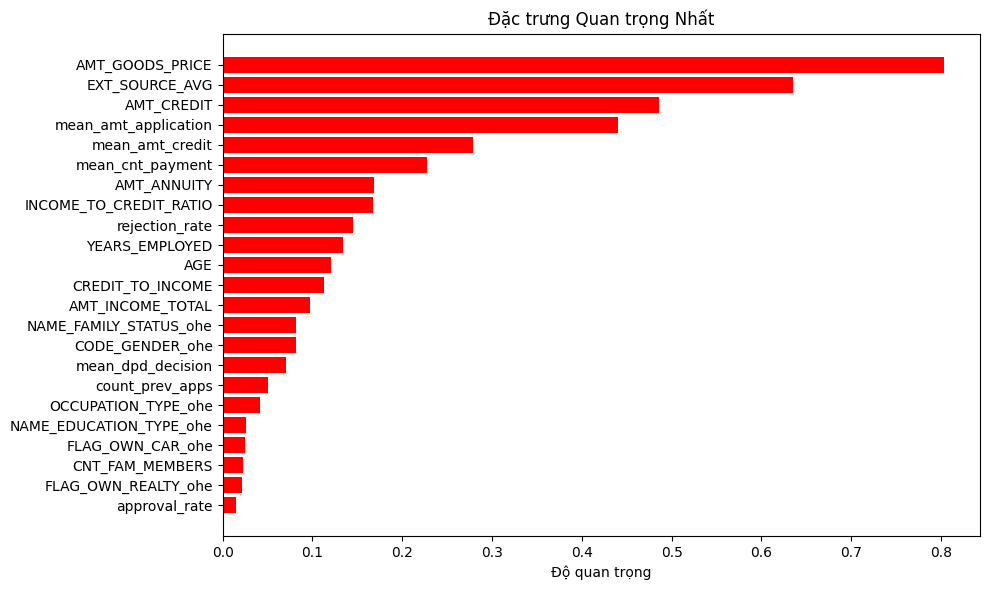

In [ ]:
# Feature Importance
assembler_stage = model.stages[-3]  # VectorAssembler là stage thứ 3 từ cuối
feature_names = assembler_stage.getInputCols()
feature_importance = model.stages[-1].coefficients.toArray()

if len(feature_names) != len(feature_importance):
    print(f"Cảnh báo: Độ dài không khớp giữa feature_names ({len(feature_names)}) và feature_importance ({len(feature_importance)})")
    min_len = min(len(feature_names), len(feature_importance))
    feature_names = feature_names[:min_len]
    feature_importance = feature_importance[:min_len]

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(feature_importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='red')
plt.xlabel('Độ quan trọng')
plt.title('Đặc trưng Quan trọng Nhất')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png')

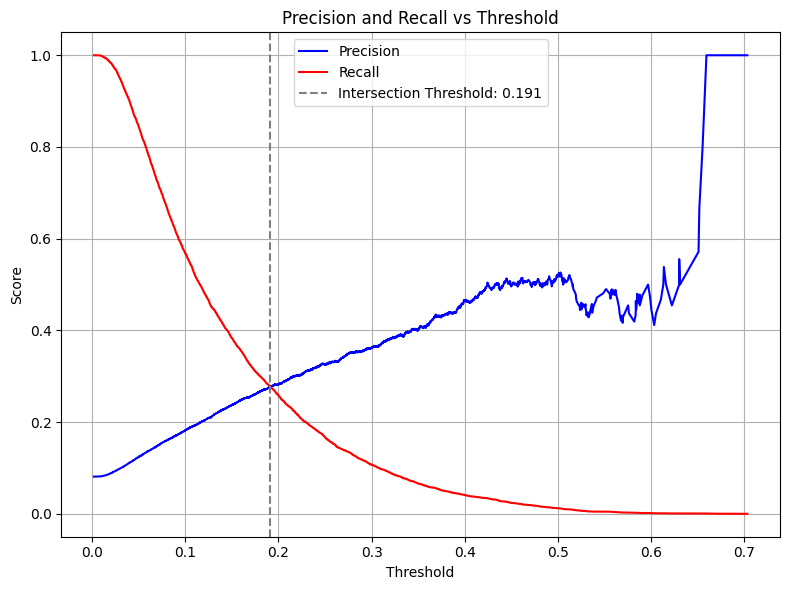

Intersection Threshold: 0.191
Precision at Intersection: 0.278
Recall at Intersection: 0.278
AUC: 0.744


In [ ]:

    # Precision-Recall vs Threshold
    from sklearn.metrics import precision_recall_curve
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_prob)

    # Tìm ngưỡng tại điểm giao cắt gần nhất giữa Precision và Recall
    diff = np.abs(precision_vals[:-1] - recall_vals[:-1])
    intersection_idx = np.argmin(diff)
    intersection_threshold = thresholds[intersection_idx]

    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision_vals[:-1], 'b-', label='Precision')
    plt.plot(thresholds, recall_vals[:-1], 'r-', label='Recall')
    plt.axvline(x=intersection_threshold, color='gray', linestyle='--', label=f'Intersection Threshold: {intersection_threshold:.3f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs Threshold')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    print(f"Intersection Threshold: {intersection_threshold:.3f}")
    print(f"Precision at Intersection: {precision_vals[intersection_idx]:.3f}")
    print(f"Recall at Intersection: {recall_vals[intersection_idx]:.3f}")
    print(f"AUC: {roc_auc:.3f}")

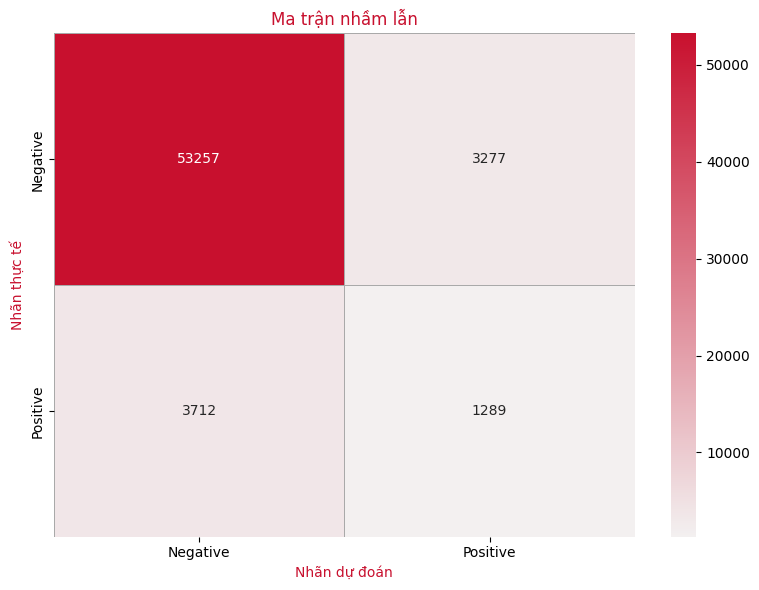

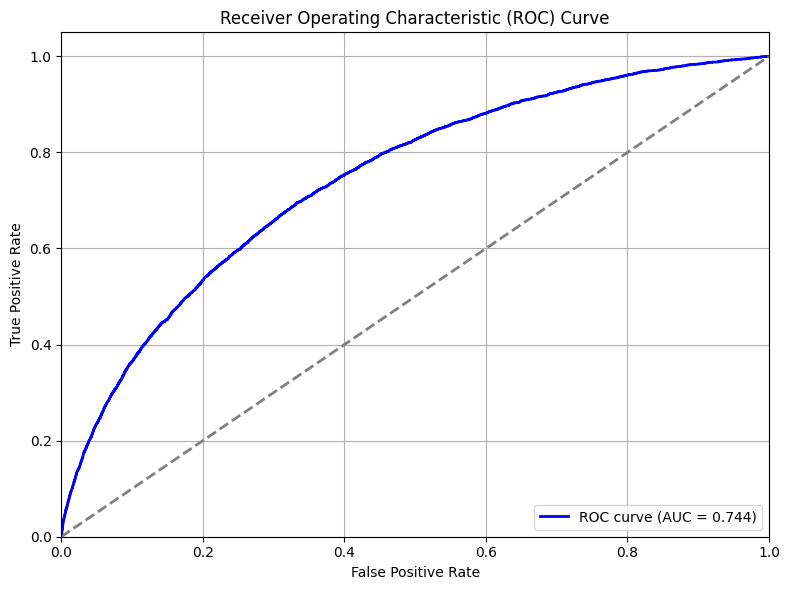

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
# Sử dụng gradient màu từ trắng đến đỏ đậm
red_gradient = sns.light_palette("#C8102E", as_cmap=True)
sns.heatmap(cm, annot=True, fmt='d', cmap=red_gradient,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
            linewidths=0.5, linecolor='#A9A9A9')  # Viền màu xám nhạt
plt.xlabel('Nhãn dự đoán', color='#C8102E')  # Nhãn màu đỏ đậm
plt.ylabel('Nhãn thực tế', color='#C8102E')
plt.title('Ma trận nhầm lẫn', color='#C8102E')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc_value = sklearn_auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig('roc_curve.png')